In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.6 MB/s eta 0:00:00


# Importing Libraries

In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F



RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Sentiment_Analysis/IMDB Dataset.csv")


In [5]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Data Preprocessing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize

def data_preprocessing(text):
  text = text.lower() # Converting to lower case
  text = re.sub(r"http\S+|www\S+|https\S+", "", text) #url removal
  text = re.sub(r"@\w+", "", text) # mention removal
  text = re.sub(r"#\w+", "", text) # hashtag removal

  #remove contractions
  text = re.sub(r"won't", "will not", text)
  text = re.sub(r"can't", "cannot", text)
  text = re.sub(r"n't", " not", text)
  text = re.sub(r"'re", " are", text)
  text = re.sub(r"'s", " is", text)
  text = re.sub(r"'d", " would", text)
  text = re.sub(r"'ll", " will", text)
  text = re.sub(r"'t", " not", text)
  text = re.sub(r"'ve", " have", text)
  text = re.sub(r"'m", " am", text)

  text = re.sub(r"[^a-zA-Z]", " ", text) #punctuation removal

  word_tokens = word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  filtered_sentence = [w for w in word_tokens if not w in stop_words]
  text = ' '.join(filtered_sentence)
  return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data['content'] = data['review'].apply(lambda x: data_preprocessing(x))
data['sentiment'] = data['sentiment'].map({'positive':1,'negative':0})
data.head()

,review,sentiment,content
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,1,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei love time money visually stunnin...


In [ ]:
data.drop(columns = ['review'], axis = 1, inplace = True)
data.head()

,sentiment,content
0,1,one reviewers mentioned watching oz episode ho...
1,1,wonderful little production br br filming tech...
2,1,thought wonderful way spend time hot summer we...
3,0,basically family little boy jake thinks zombie...
4,1,petter mattei love time money visually stunnin...


In [ ]:
df = data.copy()
df

,sentiment,content
0,1,one reviewers mentioned watching oz episode ho...
1,1,wonderful little production br br filming tech...
2,1,thought wonderful way spend time hot summer we...
3,0,basically family little boy jake thinks zombie...
4,1,petter mattei love time money visually stunnin...
...,...,...
49995,1,thought movie right good job creative original...
49996,0,bad plot bad dialogue bad acting idiotic direc...
49997,0,catholic taught parochial elementary schools n...
49998,0,going disagree previous comment side maltin on...


# Importing the BERT model

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

## Creating Dataset

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len, include_raw_text = False):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.include_raw_text = include_raw_text

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      truncation = True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    output = {
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

    if self.include_raw_text:
      output['review_text'] = review

    return output




In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((45000, 2), (2500, 2), (2500, 2))

# Creating Dataloaders

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size, include_raw_text = False):
  ds = GPReviewDataset(
    reviews=df.content.to_list(),
    targets=df.sentiment.to_list(),
    tokenizer=tokenizer,
    max_len=max_len,
    include_raw_text = include_raw_text
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [ ]:
BATCH_SIZE = 16
MAX_LEN = 512

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE, include_raw_text = True)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE, include_raw_text = True)

print(len(train_data_loader))
print(len(val_data_loader))
print(len(test_data_loader))

2813
157
157


Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

Building our own BERT model for our task Sentiment classification.

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(n_classes = 2)
model = model.to(device)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face.

In [ ]:
EPOCHS = 8

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation.<br>
Let's continue with writing a function for training our model for one epoch:

### Training function

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets).cpu()
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

### Testing Function

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets).cpu()
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


Writing a loop to train our model

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/8
----------
Train loss 0.5064855879758691 accuracy 0.7363777777777778
Val   loss 0.3537367565711592 accuracy 0.8752

Epoch 2/8
----------
Train loss 0.35306436391769147 accuracy 0.8742
Val   loss 0.5018099800796266 accuracy 0.74

Epoch 3/8
----------
Train loss 0.310441043278897 accuracy 0.8911555555555556
Val   loss 0.408788846615868 accuracy 0.86

Epoch 4/8
----------
Train loss 0.2683703110646357 accuracy 0.9076444444444445
Val   loss 0.2673449470975976 accuracy 0.896

Epoch 5/8
----------
Train loss 0.23453145560358546 accuracy 0.9262888888888889
Val   loss 0.3159084953960909 accuracy 0.902

Epoch 6/8
----------
Train loss 0.21088680336890836 accuracy 0.9381555555555555
Val   loss 0.3816922138486603 accuracy 0.89

Epoch 7/8
----------
Train loss 0.18792773047170758 accuracy 0.9491111111111111
Val   loss 0.4439990351356234 accuracy 0.8892

Epoch 8/8
----------
Train loss 0.1777931299955156 accuracy 0.9537555555555556
Val   loss 0.3895650246554309 accuracy 0.9028

CPU times:

#### Let's save our model.

In [ ]:
path = "/content/drive/My Drive/Sentiment_Analysis"

torch.save(model.state_dict(), path + '/best_model_state.bin')


In [ ]:
# Define your model with the same architecture
model = SentimentClassifier(n_classes=2)

# Load the saved model state_dict
model.load_state_dict(torch.load(path + '/best_model_state.bin'))

# Make sure to send the model to the same device it was trained on
model = model.to(device)

## Ploting our training curve for accuracy.

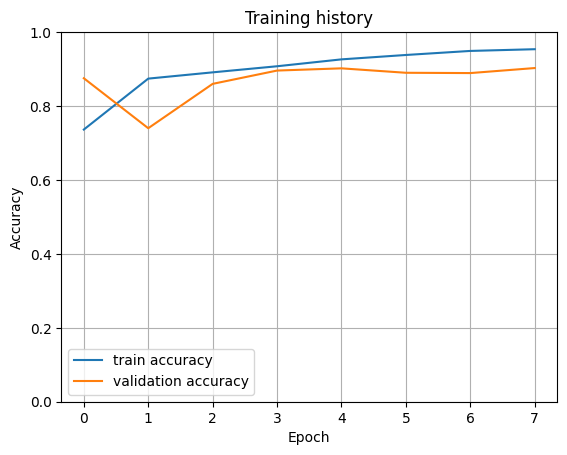

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.ylim([0, 1]);

Both training and validation accuracy improves/increases over epochs.

## Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8992

# Making Predictions

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [ ]:
class_names = ['negative', 'positive']

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.90      0.89      0.90      1232
    positive       0.90      0.91      0.90      1268

    accuracy                           0.90      2500
   macro avg       0.90      0.90      0.90      2500
weighted avg       0.90      0.90      0.90      2500



Let's continue with confusion matrix.

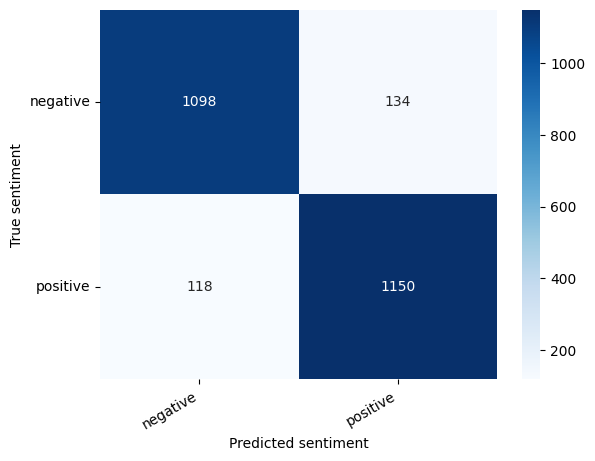

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)



That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
idx = 3

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

atrocious waste time plot acting far par used exemplar acting classes
merely commercial rip earlier universal soldier also scrapes bottom
acting barrel sad vd needs assert ego every years sadder still people
pay good money sit thru kind schlock gives martial arts movies bad
name comparison makes segall norris arnold look almost talented br br
perhaps vd take leslie nielson track send ups genre least could
laughing instead

True sentiment: negative


Now we can look at the confidence of each sentiment of our model:

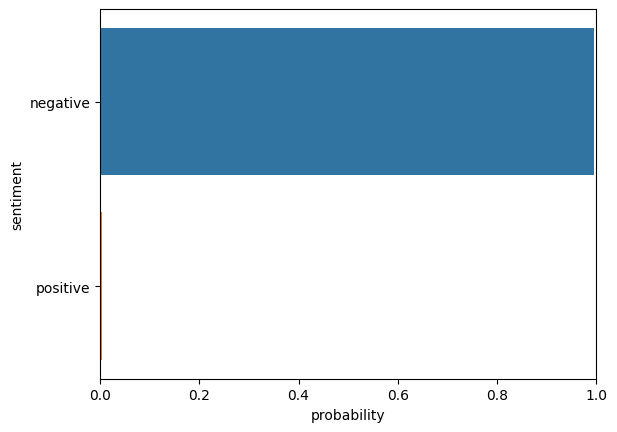

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "Thank you for putting in the extra effort during this busy time at work. I understand that staying late isn't easy, but the team truly appreciates it. You are a valuable member of our team, and your positive attitude has helped us all continue to feel motivated."

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Thank you for putting in the extra effort during this busy time at work. I understand that staying late isn't easy, but the team truly appreciates it. You are a valuable member of our team, and your positive attitude has helped us all continue to feel motivated.
Sentiment  : positive
